In [1]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter
import re

from math import sqrt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.preprocessing.text import Tokenizer
import string
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from keras import backend as K
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense, Embedding, GlobalMaxPool1D
from tensorflow.keras.layers import Conv1D, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, TextVectorization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

tf.keras.utils.set_random_seed(7)
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)
pd.set_option('max_colwidth', 600)

In [2]:

!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [3]:
!pip install -q -U keras-tuner
import keras_tuner as kt
from keras_tuner import Objective, HyperParameters

     |████████████████████████████████| 135 kB 30.1 MB/s 
     |████████████████████████████████| 1.6 MB 50.1 MB/s 


In [4]:
import yfinance as yf

In [5]:
!pip install talib-binary
import talib as ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.4 MB 39.7 MB/s 


In [6]:
#getting initial stock data
stock="INTC"
obj = yf.Ticker(stock)
stock_data=obj.history(interval="1d", start="2012-10-01", end="2022-09-30")

In [7]:
#data shape
stock_data.shape

(2516, 7)

In [8]:
stock_data.shape

(2516, 7)

In [9]:
stock_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-10-01 00:00:00-04:00,16.925170,17.237634,16.873093,16.932610,55261300,0.0,0
2012-10-02 00:00:00-04:00,17.029318,17.111155,16.858207,16.992121,36381100,0.0,0
2012-10-03 00:00:00-04:00,17.007008,17.088843,16.731741,16.776379,49772700,0.0,0
2012-10-04 00:00:00-04:00,16.798698,16.828457,16.568070,16.716862,52980100,0.0,0
2012-10-05 00:00:00-04:00,16.858211,17.036762,16.798694,16.873091,38344600,0.0,0


In [10]:
#removing dividends and stocks splits
data=stock_data.iloc[:, :5]

In [11]:
#data.to_csv("aapl_prices_vol.csv")

Text(0.5, 0, '')

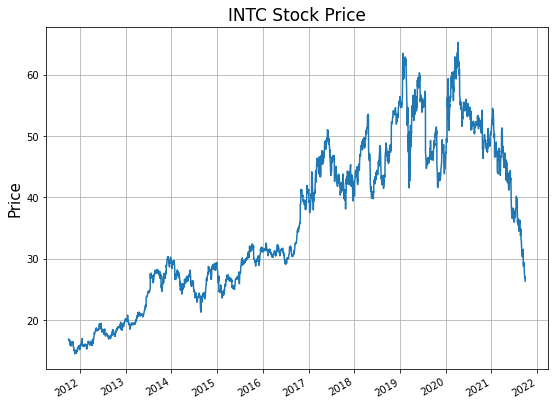

In [12]:
#plot of stock price over the 10-year period
data["Close"].plot(figsize=(9,7))
plt.grid(True)
plt.title("{} Stock Price".format(stock), size =17)
plt.ylabel("Price", size=15)
plt.xlabel("")

In [13]:
#adding technical indicators
seq_len=21
data["MA_20"]= ta.SMA(data["Close"], timeperiod=20)
data["MA_50"]= ta.SMA(data["Close"], timeperiod=50)
data["EXP_MA_20"]= ta.EMA(data["Close"], timeperiod=20)
data["EXP_MA_50"]= ta.EMA(data["Close"], timeperiod=50)
data["RSI"] =ta.RSI(data["Close"],timeperiod=seq_len)
data["MACD"],data["MACD_sign"], data["MACD_hist"]  =ta.MACD( data["Close"].values )
data["BB_upper"], data["BB_middle"], data["BB_lower"] = ta.BBANDS(data["Close"], timeperiod=seq_len, nbdevup=2, nbdevdn=2, matype=0)
data["PPO"]= ta.PPO(data["Close"])
data["MOM"]=ta.MOM(data["Close"], timeperiod=seq_len)
data["Rate_Of_Change"]=ta.ROCP(data["Close"], timeperiod=1)

In [14]:
#data.to_csv("aapl_prices_vol_tech.csv")

In [15]:
#technical variables have up to 50 days as n/a due to how they are constructed (example 50-day moving avarage)
data.head()

,Open,High,Low,Close,Volume,MA_20,MA_50,EXP_MA_20,EXP_MA_50,RSI,MACD,MACD_sign,MACD_hist,BB_upper,BB_middle,BB_lower,PPO,MOM,Rate_Of_Change
Date,,,,,,,,,,,,,,,,,,,
2012-10-01 00:00:00-04:00,16.925170,17.237634,16.873093,16.932610,55261300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-02 00:00:00-04:00,17.029318,17.111155,16.858207,16.992121,36381100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003515
2012-10-03 00:00:00-04:00,17.007008,17.088843,16.731741,16.776379,49772700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.012697
2012-10-04 00:00:00-04:00,16.798698,16.828457,16.568070,16.716862,52980100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003548
2012-10-05 00:00:00-04:00,16.858211,17.036762,16.798694,16.873091,38344600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009346


In [16]:
#removing the n/a's from technical variable creation
data=data.iloc[49:,:]

In [17]:
data.head()

,Open,High,Low,Close,Volume,MA_20,MA_50,EXP_MA_20,EXP_MA_50,RSI,MACD,MACD_sign,MACD_hist,BB_upper,BB_middle,BB_lower,PPO,MOM,Rate_Of_Change
Date,,,,,,,,,,,,,,,,,,,
2012-12-12 00:00:00-05:00,15.679001,15.776712,15.438480,15.536191,48354700,14.999148,15.733922,15.207997,15.733922,48.919200,-0.118377,-0.244777,0.126400,15.527858,15.010762,14.493666,-0.762093,-0.075159,0.000969
2012-12-13 00:00:00-05:00,15.506119,15.724092,15.363310,15.400891,41607600,15.019066,15.703288,15.226368,15.720862,47.072856,-0.090854,-0.213992,0.123138,15.552951,15.018278,14.483605,-0.294983,0.157842,-0.008709
2012-12-14 00:00:00-05:00,15.423440,15.588798,15.295663,15.430957,34149500,15.037857,15.672065,15.245853,15.709494,47.534881,-0.065857,-0.184365,0.118508,15.601353,15.038680,14.476006,-0.040164,0.428430,0.001952
2012-12-17 00:00:00-05:00,15.445991,15.551220,15.303183,15.461024,34959900,15.052138,15.645758,15.266345,15.699750,48.011434,-0.043123,-0.156117,0.112994,15.648797,15.058008,14.467218,0.440792,0.405886,0.001949
2012-12-18 00:00:00-05:00,15.543702,15.776706,15.461022,15.754157,41601200,15.078820,15.626504,15.312803,15.701883,52.434192,-0.001437,-0.125181,0.123744,15.745626,15.085567,14.425508,0.986212,0.578753,0.018959


In [18]:
#checking that there are no NAs.
print(data.isna().sum())

Open              0
High              0
Low               0
Close             0
Volume            0
MA_20             0
MA_50             0
EXP_MA_20         0
EXP_MA_50         0
RSI               0
MACD              0
MACD_sign         0
MACD_hist         0
BB_upper          0
BB_middle         0
BB_lower          0
PPO               0
MOM               0
Rate_Of_Change    0
dtype: int64


In [19]:
#creating X features  in the shape of [observations by time steps by features], which is neccessary for LSTMs. The y labels are in vector shape. 
X_samples=[]
y_samples=[]
num_features=data.shape[1]
num_rows=len(data)
#time steps are approximetly a month
seq_len=21

for i in range(seq_len, num_rows):
  x_step=data[i-seq_len: i]
  y_step=data["Close"][i]
  X_samples.append(x_step)
  y_samples.append(y_step)

X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0], X_data.shape[1], num_features)
print(X_data.shape)

y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0],1)

#checking shape
print(y_data.shape)

(2446, 21, 19)
(2446, 1)


In [20]:
#X_data[-1]

In [21]:
#data.tail()

In [22]:
#creating train and validation sets for hyperparameter tuning. (X_test is created for completeness
# but will not be utilized in the hyperparameter tunning stage. Instead a final test set will be created below for use in the final model
#after hyperparameter tunning is complete)  

# Choosing the number of validation set observations
valsplit=500
testsplit=250
# Splitting the data into train and validation sets
X_train=X_data[:-valsplit]
X_val=X_data[-valsplit:-testsplit]
X_test=X_data[-testsplit:]
y_train=y_data[:-valsplit]
y_val=y_data[-valsplit:-testsplit]
y_test=y_data[-testsplit:]

In [23]:
# Printing the shape of training and validation
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Validation Data shape ####')
print(X_val.shape)
print(y_val.shape)
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(1946, 21, 19)
(1946, 1)

#### Validation Data shape ####
(250, 21, 19)
(250, 1)

#### Testing Data shape ####
(250, 21, 19)
(250, 1)


In [24]:
#using MinMaxScaler to fit_transform on the train set and then just transform on the validation set so as to avoid data leakage 
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

scaler_y=MinMaxScaler()
y_train=scaler_y.fit_transform(y_train)
y_val=scaler_y.transform(y_val)
y_test=scaler_y.transform(y_test)

In [25]:
#Creating final train and test sets. This data is for the final model after the best model using hyperparameter tuning has been identified. 
#the train set now consists of the train and validation set observations. The test set data has not been observed by any model.
# Choosing the number of testing data records
testingsplit=250
 

X_final_train=X_data[:-testingsplit]
X_final_test=X_data[-testingsplit:]
y_final_train=y_data[:-testingsplit]
y_final_test=y_data[-testingsplit:]

In [26]:
print('\n#### Training Data shape ####')
print(X_final_train.shape)
print(y_final_train.shape)

print('\n#### Testing Data shape ####')
print(X_final_test.shape)
print(y_final_test.shape)


#### Training Data shape ####
(2196, 21, 19)
(2196, 1)

#### Testing Data shape ####
(250, 21, 19)
(250, 1)


In [27]:
#scalling the data for the final analysis after the train-validation stage. The scaler is different from before as it scales the train data set that is now composed of 
#the train and validation sets.
scaler_final_X=MinMaxScaler()
X_final_train = scaler_final_X.fit_transform(X_final_train.reshape(-1, X_final_train.shape[-1])).reshape(X_final_train.shape)
X_final_test = scaler_final_X.transform(X_final_test.reshape(-1, X_final_test.shape[-1])).reshape(X_final_test.shape)

scaler_final_y=MinMaxScaler()
y_final_train=scaler_final_y.fit_transform(y_final_train)
y_final_test=scaler_final_y.transform(y_final_test)

##Helpful Model Fitting and Results Functions

In [28]:
#function for compiling and training the model. 
def compile_train_model(model, x_train, y_train,  epochs=100, x_valid=None, y_valid=None, patience=3, optimizer='adam', final_model=False):
    
  
    # Compile
    model.compile(optimizer=optimizer,
                loss = 'mse',
                metrics=['mse'])
    

  # Train if final model there is no validation set.
    if final_model:
     
      history = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=32,
        verbose=1,
        callbacks=[    
          EarlyStopping(monitor='mse', patience=patience, restore_best_weights=True, verbose=0)]
            )
      
    else:
     
      history = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(x_valid, y_valid),
        verbose=1,
        callbacks=[    
          EarlyStopping(monitor='val_mse', patience=patience, restore_best_weights=True, verbose=0)]
            )
    return history, model   
    

In [29]:
#creating function for charts of train vs validation loss functions
def train_val_loss_charts(model_history, model_num):
    model_df=pd.DataFrame(model_history.history)

    model_df[["loss","val_loss"]].plot(figsize=(9,7))
    plt.grid(True)
    plt.title("LSTM - Train vs. Validation Loss for {}".format(model_num), size =17)
    plt.xlabel("Epochs", size=15)

    plt.show()    

In [30]:
#from https://www.statology.org/matplotlib-abline/
def abline(slope, intercept):
     axes = plt.gca()
     x_vals = np.array(axes.get_xlim())
     y_vals = intercept + slope * x_vals
     plt.plot(x_vals, y_vals, '--', color="red")

In [31]:
#creating rmse, MAPE, MAE and R calculation for price levels using inverese_transform on the y_scaller

def price_level_evaluation_stats(model, X_train, y_train, X_test, y_test, stock, final_model=False):
    
    if final_model:

      #getting final model predictions for train and test
      train_predict=model.predict(X_train, verbose=0)
      test_predict=model.predict(X_test, verbose=0)

      #unscaling to get price level predictions
      train_predict_level=scaler_final_y.inverse_transform(train_predict)
      test_predict_level=scaler_final_y.inverse_transform(test_predict)

      #unscaling actual values
      train_actual_level=scaler_final_y.inverse_transform(y_train)
      test_actual_level=scaler_final_y.inverse_transform(y_test)

      #calculating MSE
      train_RMSE=sqrt(MSE(train_actual_level,train_predict_level ))
      test_RMSE=sqrt(MSE(test_actual_level,test_predict_level ))

      print("Final Model - Train Set RMSE: {}".format(train_RMSE))
      print("Final Model - Test Set RMSE: {}".format(test_RMSE))
      print("\n")
      #calculating MAPE
      train_MAPE=MAPE(train_actual_level,train_predict_level )
      test_MAPE=MAPE(test_actual_level,test_predict_level )

      print("Final Model - Train Set MAPE: {}".format(train_MAPE))
      print("Final Model - Test Set MAPE: {}".format(test_MAPE))
      print("\n")

      #calculating MAE
      train_MAE=MAE(train_actual_level,train_predict_level )
      test_MAE=MAE(test_actual_level,test_predict_level )

      print("Final Model - Train Set MAE: {}".format(train_MAE))
      print("Final Model - Test Set MAE: {}".format(test_MAE))
      print("\n")

      #calculating correl_coefficent between actual and predicted
      train_R=np.corrcoef(train_actual_level.reshape(-1),train_predict_level.reshape(-1) )
      test_R=np.corrcoef(test_actual_level.reshape(-1),test_predict_level.reshape(-1) )

      print("Final Model - Train Set R: {}".format(np.round(train_R[0,1],4)))
      print("Final Model - Test Set R: {}".format(np.round(test_R[0,1],4)))
      print("\n")

      #model_df=pd.DataFrame(model_history.history)

      #model_df[["loss","val_loss"]].plot(figsize=(9,7))
      plt.figure(figsize=(9, 7))
      plt.scatter(test_actual_level.reshape(-1),test_predict_level.reshape(-1))
      plt.grid(True)
      plt.title("LSTM - Actual vs. Predicted {} Prices Scatterplot".format(stock), size =17)
      plt.xlabel("Actual", size=15)
      plt.ylabel("Predictions", size=15)
      abline(1,0)
      plt.show() 
    
    else:

      #getting model predictions for train and val 
      train_predict=model.predict(X_train, verbose=0)
      val_predict=model.predict(X_test, verbose=0)
     

      #unscaling to get price level predictions
      train_predict_level=scaler_y.inverse_transform(train_predict)
      val_predict_level=scaler_y.inverse_transform(val_predict)
      

      #unscaling actual values
      train_actual_level=scaler_y.inverse_transform(y_train)
      val_actual_level=scaler_y.inverse_transform(y_test)
      

      #calculating RMSE
      train_RMSE=sqrt(MSE(train_actual_level,train_predict_level ))
      val_RMSE=sqrt(MSE(val_actual_level,val_predict_level ))
      
      print("Train Set RMSE: {}".format(train_RMSE))
      print("Val Set RMSE: {}".format(val_RMSE))
      print("\n")

      #calculating MAPE
      train_MAPE=MAPE(train_actual_level,train_predict_level )
      val_MAPE=MAPE(val_actual_level,val_predict_level )
      
      print("Train Set MAPE: {}".format(train_MAPE))
      print("Val Set MAPE: {}".format(val_MAPE))
      print("\n")

      #calculating MAPE
      train_MAE=MAE(train_actual_level,train_predict_level )
      val_MAE=MAE(val_actual_level,val_predict_level )
      

      print("Train Set MAE: {}".format(train_MAE))
      print("Val Set MAE: {}".format(val_MAE))
      print("\n")

      #calculating correl_coefficent between actual and predicted
      train_R=np.corrcoef(train_actual_level.reshape(-1),train_predict_level.reshape(-1) )
      val_R=np.corrcoef(val_actual_level.reshape(-1),val_predict_level.reshape(-1) )
      

      print("Train Set R: {}".format(np.round(train_R[0,1],4)))
      print("Val Set R: {}".format(np.round(val_R[0,1],4)))
      print("\n")

      plt.figure(figsize=(9, 7))
      plt.scatter(val_actual_level.reshape(-1),val_predict_level.reshape(-1))
      plt.grid(True)
      plt.title("LSTM - Actual vs. Predicted {} Prices Scatterplot".format(stock), size =17)
      plt.xlabel("Actual", size=15)
      plt.ylabel("Predictions", size=15)
      abline(1,0)
      plt.show()


In [32]:
def actual_predicted_test_set_chart(model, X_final_test,y_final_test, model_number):
      #getting final model predictions for test set
      test_predict=model.predict(X_final_test,verbose=0)

      #unscaling to get price level predictions
      test_predict_level=scaler_final_y.inverse_transform(test_predict)

      #unscaling actual values
      test_actual_level=scaler_final_y.inverse_transform(y_final_test)

      #creating dataframe and setting dates as the index
      df_actual_predicted=pd.DataFrame([test_predict_level.reshape(-1), test_actual_level.reshape(-1)]).T
      df_actual_predicted.rename(columns={0: "Predicted", 1: "Actual"}, inplace=True)
      df_actual_predicted["dates"]=data.index[-250:]
      df_actual_predicted.set_index("dates", inplace=True)

      #creating chart of Predicted vs. Actual
      df_actual_predicted[["Predicted", "Actual"]].plot(figsize=(9,7))
      plt.grid(True)
      plt.title("LSTM - Actual vs. Predicted Prices: {}".format(model_number), size =17)
      plt.ylabel("Price", size=15)
      plt.xlabel("")
      


In [33]:
def actual_predicted_train_test_set_chart(model, X_train, y_train, X_test, y_test, stock):
      #getting final model predictions for train and test
      train_predict=model.predict(X_train, verbose=0)
      test_predict=model.predict(X_test, verbose=0)

      #unscaling to get price level predictions
      train_predict_level=scaler_final_y.inverse_transform(train_predict)
      test_predict_level=scaler_final_y.inverse_transform(test_predict)

      #unscaling actual values
      train_actual_level=scaler_final_y.inverse_transform(y_train)
      test_actual_level=scaler_final_y.inverse_transform(y_test)

      #combine time series
      total_actual_level=np.concatenate((train_actual_level,test_actual_level))
      total_predict_level=np.concatenate((train_predict_level, test_predict_level))

      #creating dataframe and setting dates as the index
      df_actual_predicted=pd.DataFrame([total_predict_level.reshape(-1), total_actual_level.reshape(-1)]).T
      df_actual_predicted.rename(columns={0: "Predicted", 1: "Actual Prices"}, inplace=True)
      df_actual_predicted["dates"]=data.index[-2446:]
      df_actual_predicted.set_index("dates", inplace=True)
      #separating the train and test set into separate series so as to use different colors
      df_actual_predicted['Predicted Prices Train Set'] = np.where(df_actual_predicted.index<="2021-10-04", df_actual_predicted["Predicted"], np.NaN)
      df_actual_predicted['Predicted Prices Test Set'] = np.where(df_actual_predicted.index>="2021-10-04", df_actual_predicted["Predicted"], np.NaN)
      
      #creating chart of Predicted vs. Actual 

      #cycler to assign different colors, linestyles and linewidths to the three series
      cycler = plt.cycler(color= ['k','g','b'],
                          linestyle=['-', '-', '-'],
                          linewidth=[1,1.5,1.5])
                   
      fig, ax = plt.subplots()
      ax.set_prop_cycle(cycler)
      df_actual_predicted[["Actual Prices",'Predicted Prices Train Set', 'Predicted Prices Test Set']].plot(figsize=(9,7), ax=ax)
      plt.grid(True)
      
      plt.title("LSTM - Actual vs. Predicted Prices: {}".format(model_number), size =17)
      plt.ylabel("Price", size=15)
      plt.xlabel("")
      
     

In [34]:
# Function for creating confusion matrix

#class names for confusion matrix
class_names = ["Price Down Next Day", "Price Up Next Day"]


def confusion_matrix_stocks(model_for_matrix, predicted_values, actual_test_labels, model_num):
    



    #creating confusion matrix - using test set labels as they were already sparse before one-hot encoding
    confusion_matrix_for_model = confusion_matrix(actual_test_labels ,  predicted_values)


    confusion_matrix_df = pd.DataFrame(confusion_matrix_for_model,
                    
                     index=class_names,
                     columns=class_names)

    #Plotting the confusion matrix
    plt.figure(figsize=(10,8))
    ax=sns.heatmap(confusion_matrix_df,annot=True, fmt="d", cmap="rocket_r", annot_kws={"size":25})
    cax = ax.figure.axes[-1]
    cax.tick_params(labelsize=22)
    plt.title('LSTM - Confusion Matrix - {}'.format(model_num), size=25)
    plt.ylabel('Actual Labels', size=22)
    plt.xlabel('Predicted Labels',size=22)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()  

In [35]:
def test_set_classification_report(model, X_final_test,y_final_test, model_number):
      #getting final model predictions for train and test
      test_predict=model.predict(X_test, verbose=0)

      #unscaling to get price level predictions
      test_predict_level=scaler_final_y.inverse_transform(test_predict)

      #unscaling actual values
      test_actual_level=scaler_final_y.inverse_transform(y_test)
      
      #creating dataframe 
      df_actual_predicted=pd.DataFrame([test_predict_level.reshape(-1), test_actual_level.reshape(-1)]).T
      df_actual_predicted.rename(columns={0: "Predicted", 1: "Actual"}, inplace=True)
      
      #creating forecasted signal for next day from past day actual price. 0 if level price forecast is less than or equal to yesterday's actual price, and
      #1 for above. 
      predicted_signal=[0]
      for i in range(1,250):
        if df_actual_predicted.iloc[i, 0]>df_actual_predicted.iloc[i-1,1]:
          predicted_signal.append(1)
        else:
          predicted_signal.append(0)
      #creating  signal for next day from past day actual price. 0 if level of actual next day price is less than or equal to yesterday's actual price, and
      #1 for above.
      actual_signal=[0]
      for i in range(1,250):
        if df_actual_predicted.iloc[i, 1]>df_actual_predicted.iloc[i-1,1]:
          actual_signal.append(1)
        else:
          actual_signal.append(0)
      print(classification_report(actual_signal[1:], predicted_signal[1:]))
      accuracy=accuracy_score(actual_signal[1:], predicted_signal[1:])

      print("Test Set Accuracy for {} is {}".format(model_number, accuracy))
      print("\n")
      print("\n")
      
      confusion_matrix_stocks(model,predicted_signal[1:], actual_signal[1:], model_number)
      
      
      

##Model Hyper-parameter Tuning using Train and Validation Set 

In [36]:
#Time2Vec class implementation. Code adjusted from https://medium.com/@dave.cote.msc/hands-on-advanced-deep-learning-time-series-forecasting-with-tensors-7facae522f18

class Time2Vec(layers.Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vec, self).__init__()
    self.seq_len=seq_len

  def build(self, input_shape):

    self.weights_linear=self.add_weight(name="beta_linear", 
                                       shape=(int(self.seq_len),),
                                       initializer="uniform",
                                       trainable=True)
    self.bias_linear=self.add_weight(name="bias_linear", 
                                       shape=(int(self.seq_len),),
                                       initializer="uniform",
                                       trainable=True)
    self.weights_periodic=self.add_weight(name="beta_periodic", 
                                       shape=(int(self.seq_len),),
                                       initializer="uniform",
                                       trainable=True)
    self.bias_periodic=self.add_weight(name="bias_periodic", 
                                       shape=(int(self.seq_len),),
                                       initializer="uniform",
                                       trainable=True)


  def call(self, x):

    x=tf.math.reduce_mean(x[:,:,:], axis=-1)
    time_linear=self.weights_linear*x + self.bias_linear
    time_linear=tf.expand_dims(time_linear, axis=-1)

    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) +self.bias_periodic)
    time_periodic=tf.expand_dims(time_periodic, axis=-1)

    return tf.concat([time_linear, time_periodic], axis=-1)

  def get_config(self):                                 
    config = super(Time2Vec, self).get_config()
    config.update({
            "seq_len": self.seq_len
            

        })
    return config



In [ ]:
#Hyperparameter tunning of LSTM model with Time2Vec

tf.keras.backend.clear_session()

def lstm_model(hp):
    
    time_embedding = Time2Vec(seq_len) #Instanciate Time2Vec embeddings
    input=Input(shape=(seq_len, 19))
    x=time_embedding(input) #get Time2Vec embeddings using inputs
    x=layers.Concatenate(axis=-1)([input, x]) #concatenate Time2Vec embeddings and inputs
    
    #Choice of 2 or 3 LSTM layers
    for i in range(hp.Int("number_layers",1,2)):
        #within each LSTM layer testing for a min of 64 units, a max of 256 nodes and any in between by 
        #multiples of 32. 
        x=LSTM(units=hp.Int('LSTM_{}_units'.format(i),min_value=64,max_value=256,step=32), return_sequences=True)(x)
        #testing for dropout of values 0.1 to 0.4 by increments of 0.1 after every hidden layer
        x=Dropout(hp.Float("dropout_{}".format(i), min_value=0.10, max_value=0.40, step=0.10))(x)
    #For last  LSTM layer testing for a min of 64 units, a max of 256 nodes and any in between by 
    #multiples of 32
    x=LSTM(units=hp.Int('LSTM_{}_units'.format(i+1),min_value=64,max_value=256,step=32))(x)
    #testing for dropout of values 0.1 to 0.4 by increments of 0.1 after every hidden layer
    x=Dropout((hp.Float("dropout_{}".format(i+1), min_value=0.10, max_value=0.40, step=0.10)))(x)
    out= Dense(1, activation='linear')(x)


    model = Model(inputs=input, outputs=out)
    
    model.compile(loss="mse", optimizer="adam", metrics=["mse"])

    return model


In [ ]:
#creating Bayesian Optimization for KerasTuner
model_tuner = kt.BayesianOptimization(
    hypermodel=lstm_model,
    objective="val_mse",
    max_trials=20,
    overwrite=True,
    directory='/content/gdrive/My Drive/Colab Notebooks/MSDS_498/keras_tuner_out',
    project_name=stock)

In [ ]:
epochs=40
patience=5

early_stopping= EarlyStopping(monitor='val_mse',patience=patience, restore_best_weights=True )

#tunning the model
model_tuner.search(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val), callbacks= [early_stopping])

Trial 20 Complete [00h 00m 17s]
val_mse: 0.0008640054729767144

Best val_mse So Far: 0.0006190904532559216
Total elapsed time: 00h 09m 05s


In [ ]:
#getting best hyperparameters
model_best_hyper_parameters=model_tuner.get_best_hyperparameters(num_trials=1)[0]

#function to print out best parameters depending on how many LSTM layers there are
def best_model_hyperparameters(bhp):
    
    num_layers=bhp.get('number_layers')
    print("Number of layers: {}".format(num_layers+1))
    print("\n")
    for i in range(0,num_layers+1):
        print("Number of units in LSTM_{}:".format(i), bhp.get("LSTM_{}_units".format(i)))
        print("Dropout in LSTM_{}:".format(i),np.round( bhp.get("dropout_{}".format(i)),3 )  )
        print("\n")
    #print("Optimizer Used: {}".format(bhp.get('optimizer')))                                                           

#printing out best model hyperparameters
best_model_hyperparameters(model_best_hyper_parameters)  

Number of layers: 2


Number of units in LSTM_0: 128
Dropout in LSTM_0: 0.1


Number of units in LSTM_1: 256
Dropout in LSTM_1: 0.1




In [ ]:
#getting paremeters of best model
model_best_params = model_tuner.get_best_hyperparameters(2)

# Building model with best hyper parameters
model_best = lstm_model(model_best_params[0])

# Running best model. 
epochs=40
patience=5
model_number=stock

history_best_model, best_model = compile_train_model(model_best,
                                    X_train,y_train, epochs=epochs,
                                     x_valid=X_val,y_valid=y_val,patience=patience,
                                    optimizer="adam")

Epoch 1/40
61/61 [==============================] - 4s 21ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 2/40
61/61 [==============================] - 1s 8ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 3/40
61/61 [==============================] - 1s 9ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 4/40
61/61 [==============================] - 1s 9ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 5/40
61/61 [==============================] - 1s 9ms/step - loss: 9.8442e-04 - mse: 9.8442e-04 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 6/40
61/61 [==============================] - 1s 9ms/step - loss: 9.5168e-04 - mse: 9.5168e-04 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 7/40
61/61 [==============================] - 1s 9ms/step - loss: 9.0082e-04 - mse: 9.0082e-04 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 8/40
61/61 [==============================] - 1s 9ms/step -

In [ ]:
best_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 21, 19)]     0           []                               
                                                                                                  
 time2_vec_1 (Time2Vec)         (None, 21, 2)        84          ['input_2[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 21, 21)       0           ['input_2[0][0]',                
                                                                  'time2_vec_1[0][0]']            
                                                                                                  
 lstm_2 (LSTM)                  (None, 21, 128)      76800       ['concatenate_1[0][0]']    

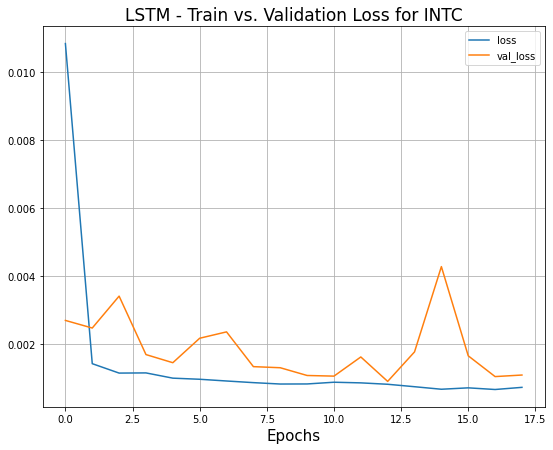

In [ ]:

train_val_loss_charts(history_best_model, model_number)

Train Set RMSE: 0.9227567117171831
Val Set RMSE: 1.4344147069954187


Train Set MAPE: 0.016564769804380017
Val Set MAPE: 0.020002591039864244


Train Set MAE: 0.5819892079587583
Val Set MAE: 1.0534238281249995


Train Set R: 0.9971
Val Set R: 0.962




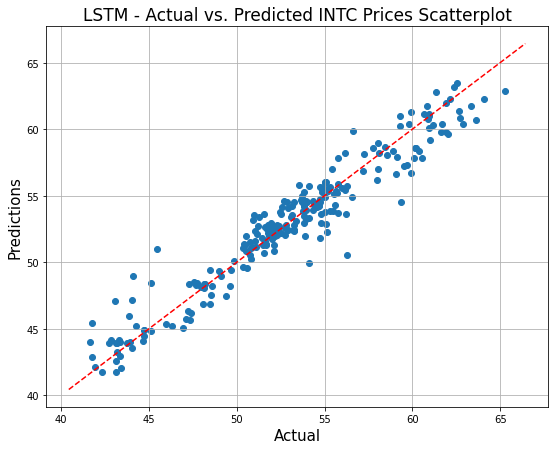

In [ ]:
price_level_evaluation_stats(best_model, X_train, y_train, X_val, y_val,stock)


In [ ]:
best_model.save( '/content/gdrive/My Drive/Colab Notebooks/MSDS_498/saved_models/lstm_model_val_INTC.h5')

In [ ]:
#model = tf.keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/MSDS_498/saved_models/lstm_model_val_AMZN.h5',custom_objects={"Time2Vec": Time2Vec })

#Final Best Model Estimation

In [ ]:
tf.keras.utils.set_random_seed(20)
#getting paremeters of best model
model_best_params = model_tuner.get_best_hyperparameters(2)

# Building model with best hyper parameters
model_best = lstm_model(model_best_params[0])

# Running best model using final train and test sets. Test set metrics will be 
#based of this model run.
epochs=40
patience=5

#best_model_optimizer=model_best_hyper_parameters.get('optimizer')
history_best_model_test, best_model_test = compile_train_model(model_best, X_final_train,y_final_train,
                                    epochs=epochs,patience=patience,
                                    optimizer="adam", final_model=True)

Epoch 1/40
69/69 [==============================] - 4s 8ms/step - loss: 0.0132 - mse: 0.0132
Epoch 2/40
69/69 [==============================] - 1s 8ms/step - loss: 0.0017 - mse: 0.0017
Epoch 3/40
69/69 [==============================] - 1s 8ms/step - loss: 0.0013 - mse: 0.0013
Epoch 4/40
69/69 [==============================] - 1s 8ms/step - loss: 0.0011 - mse: 0.0011
Epoch 5/40
69/69 [==============================] - 1s 8ms/step - loss: 0.0010 - mse: 0.0010
Epoch 6/40
69/69 [==============================] - 1s 8ms/step - loss: 8.9188e-04 - mse: 8.9188e-04
Epoch 7/40
69/69 [==============================] - 1s 8ms/step - loss: 8.9901e-04 - mse: 8.9901e-04
Epoch 8/40
69/69 [==============================] - 1s 8ms/step - loss: 7.8910e-04 - mse: 7.8910e-04
Epoch 9/40
69/69 [==============================] - 1s 8ms/step - loss: 8.3433e-04 - mse: 8.3433e-04
Epoch 10/40
69/69 [==============================] - 1s 8ms/step - loss: 7.8570e-04 - mse: 7.8570e-04
Epoch 11/40
69/69 [==========

Final Model - Train Set RMSE: 0.9317142386449672
Final Model - Test Set RMSE: 1.0906392230321071


Final Model - Train Set MAPE: 0.016060662860578556
Final Model - Test Set MAPE: 0.0199130061343933


Final Model - Train Set MAE: 0.6209480584427738
Final Model - Test Set MAE: 0.8477420425415041


Final Model - Train Set R: 0.9981
Final Model - Test Set R: 0.9891




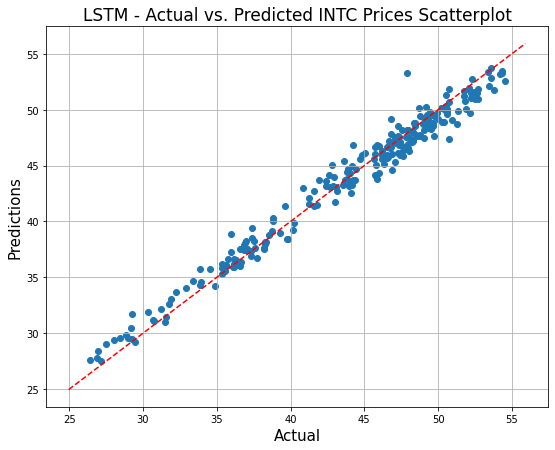

In [ ]:
price_level_evaluation_stats(best_model_test,X_final_train,y_final_train, X_final_test,y_final_test, stock, final_model=True)


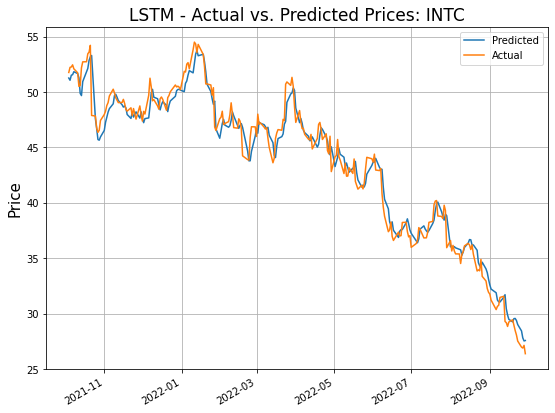

In [39]:
actual_predicted_test_set_chart(best_model_test, X_final_test,y_final_test, model_number)

              precision    recall  f1-score   support

           0       0.54      0.65      0.59       132
           1       0.49      0.38      0.43       117

    accuracy                           0.52       249
   macro avg       0.51      0.51      0.51       249
weighted avg       0.52      0.52      0.51       249

Test Set Accuracy for INTC is 0.5220883534136547






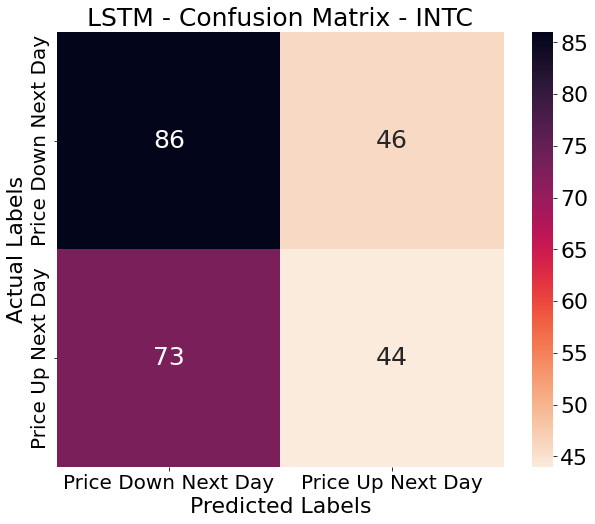

In [ ]:
test_set_classification_report(best_model_test, X_final_test,y_final_test, model_number)

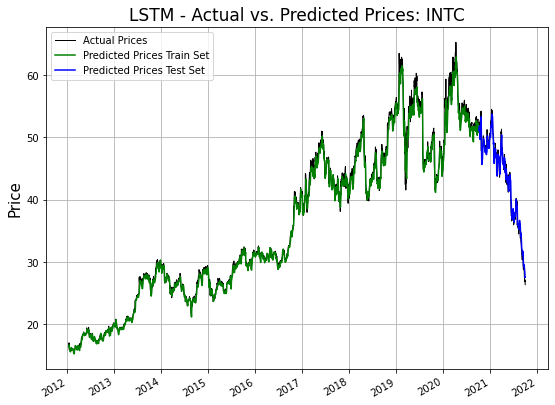

In [ ]:
actual_predicted_train_test_set_chart(best_model_test, X_final_train,y_final_train, X_final_test,y_final_test, model_number)

In [ ]:
#best_model_test.save( '/content/gdrive/My Drive/Colab Notebooks/MSDS_498/saved_models/lstm_model_test_INTC.h5')


In [38]:
best_model_test = tf.keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/MSDS_498/saved_models/lstm_model_test_INTC.h5',custom_objects={"Time2Vec": Time2Vec })

In [37]:
model_number="INTC"
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive
